# Setup

In [ ]:
!unzip '/content/gdrive/MyDrive/ErukaTraining/OC/images.zip' -d '/content/'

In [ ]:
# Installs

!pip install transformers
!pip install -q datasets jiwer
!pip install accelerate nvidia-ml-py3

# Imports

from transformers import (
    TrOCRConfig,
    TrOCRProcessor,
    TrOCRForCausalLM,
    ViTConfig,
    ViTModel,
    VisionEncoderDecoderModel,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments,
    EarlyStoppingCallback,
    default_data_collator
)

from PIL import Image
from torchvision import transforms

import csv
import fnmatch
from math import isclose
import os
import torch
from tqdm import tqdm
from torch.utils.data import DataLoader, Dataset
from datasets import load_metric
import shutil
import pandas as pd

# Mount gdrive

from google.colab import drive
content_root = '/content/'
mount_root = '/content/gdrive/'
drive_root = f'{mount_root}MyDrive/'
drive.mount(mount_root)

# Processor
# TODO: should this be trained?
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")

# Model Name
model_name = "carb-oc-fine-tuning-10k-empty"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


# Ownership Card Dataset

In [ ]:
class OCDataset(torch.utils.data.Dataset):
    @staticmethod
    def parse_csv(filepath):
        labels = {}
        with open(filepath) as f:
            f_csv = csv.reader(f)
            next(f_csv, None)  # skip the headers
            for row in f_csv:
                labels[row[0]] = row[1]
        return labels

    def __init__(self, processor, file, max_target_length=16) -> None:
        test_dir = f"{drive_root}ErukaTraining/OC/"
        labels_dict = self.parse_csv(f"{test_dir}{file}")

        self.X = []

        for parcel, raw_label in labels_dict.items():
            # Extract pixel values
            file_path = f"{content_root}images/{parcel}.jpg"
            # pixel_values.to(device)
            
            # Resolve label values
            labels = processor.tokenizer(raw_label, 
                padding="max_length", 
                max_length=max_target_length).input_ids
            # important: make sure that PAD tokens are ignored by the loss function
            labels = [label if label != processor.tokenizer.pad_token_id else -100 for label in labels]
            # labels.to(device)
            
            self.X.append({"file_path": file_path, "parcel": parcel, "raw_labels": raw_label, "labels": torch.tensor(labels)})

    def __len__(self):
        return len(self.X)

    def __getitem__(self, ind):
        x = self.X[ind]
        image = Image.open(x["file_path"]).convert("RGB")
        pixel_values = processor(image, return_tensors="pt").pixel_values.squeeze(0)

        return {"pixel_values": pixel_values, "parcel": x["parcel"], "raw_labels": x["raw_labels"], "labels": x["labels"]}

oc_dataset = OCDataset(processor, "labels.csv")
oc_test_dataset = OCDataset(processor, "labels_test.csv")

class OCEmptyDataset(torch.utils.data.Dataset):
    @staticmethod
    def parse_csv(filepath):
        labels = {}
        with open(filepath) as f:
            f_csv = csv.reader(f)
            next(f_csv, None)  # skip the headers
            for row in f_csv:
                labels[row[0]] = "_"
        return labels

    def __init__(self, processor, file, max_target_length=16) -> None:
        test_dir = f"{drive_root}ErukaTraining/OC/"
        labels_dict = self.parse_csv(f"{test_dir}{file}")

        self.X = []

        for parcel, raw_label in labels_dict.items():
            # Extract pixel values
            file_path = f"{content_root}images/{parcel}.jpg"
            # pixel_values.to(device)
            
            # Resolve label values
            labels = processor.tokenizer(raw_label, 
                padding="max_length", 
                max_length=max_target_length).input_ids
            # important: make sure that PAD tokens are ignored by the loss function
            labels = [label if label != processor.tokenizer.pad_token_id else -100 for label in labels]
            # labels.to(device)
            
            self.X.append({"file_path": file_path, "parcel": parcel, "raw_labels": raw_label, "labels": torch.tensor(labels)})

    def __len__(self):
        return len(self.X)

    def __getitem__(self, ind):
        x = self.X[ind]
        image = Image.open(x["file_path"]).convert("RGB")
        pixel_values = processor(image, return_tensors="pt").pixel_values.squeeze(0)

        return {"pixel_values": pixel_values, "parcel": x["parcel"], "raw_labels": x["raw_labels"], "labels": x["labels"]}

oc_empty_dataset = OCEmptyDataset(processor, "empty.csv")

oc_dataset = torch.utils.data.ConcatDataset([oc_dataset, oc_empty_dataset])

# CARB Dataset

In [ ]:
!wget https://www.orand.cl/orand_car/ORAND-CAR-2014.tar.gz
!tar xvzf ORAND-CAR-2014.tar.gz


Streaming output truncated to the last 5000 lines.
ORAND-CAR-2014/CAR-B/b_train_images/b_car_004006.png
ORAND-CAR-2014/CAR-B/b_train_images/b_car_003727.png
ORAND-CAR-2014/CAR-B/b_train_images/b_car_004368.png
ORAND-CAR-2014/CAR-B/b_train_images/b_car_006406.png
ORAND-CAR-2014/CAR-B/b_train_images/b_car_005617.png
ORAND-CAR-2014/CAR-B/b_train_images/b_car_005230.png
ORAND-CAR-2014/CAR-B/b_train_images/b_car_003850.png
ORAND-CAR-2014/CAR-B/b_train_images/b_car_003293.png
ORAND-CAR-2014/CAR-B/b_train_images/b_car_004967.png
ORAND-CAR-2014/CAR-B/b_train_images/b_car_005234.png
ORAND-CAR-2014/CAR-B/b_train_images/b_car_005513.png
ORAND-CAR-2014/CAR-B/b_train_images/b_car_003051.png
ORAND-CAR-2014/CAR-B/b_train_images/b_car_004463.png
ORAND-CAR-2014/CAR-B/b_train_images/b_car_005193.png
ORAND-CAR-2014/CAR-B/b_train_images/b_car_004030.png
ORAND-CAR-2014/CAR-B/b_train_images/b_car_004672.png
ORAND-CAR-2014/CAR-B/b_train_images/b_car_003002.png
ORAND-CAR-2014/CAR-B/b_train_images/b_car_005737

In [ ]:
carb_dir = f"{content_root}ORAND-CAR-2014/CAR-B/"

class CARDataset(torch.utils.data.Dataset):
    @staticmethod
    def parse_labels(filepath):
        labels = {}
        with open(filepath) as f:
            for line in f:
                tokens = line.split()
                labels[tokens[0]] = tokens[1]
        return labels

    def __init__(self, img_dir, labels_file, processor, max_target_length=16) -> None:
        labels_dict = self.parse_labels(labels_file)
        input_files = fnmatch.filter(os.listdir(img_dir), "*.png")

        self.X = []

        for input_file in input_files:
            # Extract pixel values
            file_path = f"{img_dir}{input_file}"
            
            # Resolve label values
            raw_label = labels_dict[input_file]
            labels = processor.tokenizer(raw_label, 
                padding="max_length", 
                max_length=max_target_length).input_ids
            # important: make sure that PAD tokens are ignored by the loss function
            labels = [label if label != processor.tokenizer.pad_token_id else -100 for label in labels]
            # labels.to(device)
            
            self.X.append({"file_path": file_path, "parcel": input_file, "raw_labels": raw_label, "labels": torch.tensor(labels)})

    def __len__(self):
        return len(self.X)

    def __getitem__(self, ind):
        x = self.X[ind]
        image = Image.open(x["file_path"]).convert("RGB")
        pixel_values = processor(image, return_tensors="pt").pixel_values.squeeze(0)

        return {"pixel_values": pixel_values, "parcel": x["parcel"], "raw_labels": x["raw_labels"], "labels": x["labels"]}

carb_dataset = CARDataset(f"{carb_dir}b_train_images/", f"{carb_dir}b_train_gt.txt", processor)

# Fine Tuning

OC Dataset: 7375
CARB Dataset: 3000
{'pixel_values': tensor([[[ 0.5294,  0.5294,  0.5216,  ...,  0.8275,  0.8275,  0.8275],
         [ 0.5294,  0.5294,  0.5216,  ...,  0.8275,  0.8275,  0.8275],
         [ 0.5294,  0.5294,  0.5216,  ...,  0.8275,  0.8275,  0.8275],
         ...,
         [ 0.4667,  0.4667,  0.4196,  ..., -0.3412, -0.3490, -0.3490],
         [ 0.4667,  0.4667,  0.4196,  ..., -0.3412, -0.3490, -0.3490],
         [ 0.4667,  0.4667,  0.4196,  ..., -0.3412, -0.3490, -0.3490]],

        [[ 0.5294,  0.5294,  0.5216,  ...,  0.8275,  0.8275,  0.8275],
         [ 0.5294,  0.5294,  0.5216,  ...,  0.8275,  0.8275,  0.8275],
         [ 0.5294,  0.5294,  0.5216,  ...,  0.8275,  0.8275,  0.8275],
         ...,
         [ 0.4667,  0.4667,  0.4196,  ..., -0.3412, -0.3490, -0.3490],
         [ 0.4667,  0.4667,  0.4196,  ..., -0.3412, -0.3490, -0.3490],
         [ 0.4667,  0.4667,  0.4196,  ..., -0.3412, -0.3490, -0.3490]],

        [[ 0.5294,  0.5294,  0.5216,  ...,  0.8275,  0.8275,  0

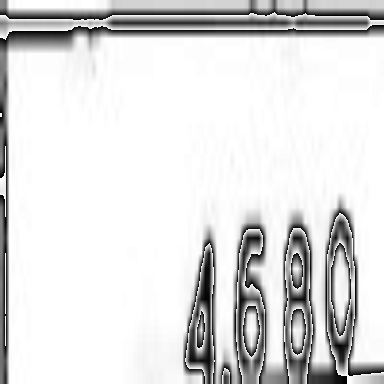

In [ ]:
print(f"OC Dataset: {len(oc_dataset)}")
print(f"CARB Dataset: {len(carb_dataset)}")
encoding = oc_dataset[0]
print(encoding)
image = encoding["pixel_values"]
print(f"pixel_values: {image.shape}")
pil_image = transforms.ToPILImage()(image)
display(pil_image)

In [ ]:
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-stage1").to("cuda")

# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size

# set beam search parameters
model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 64
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4
model.config.output_scores = True

training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy="steps",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    fp16=True, 
    output_dir="./",
    logging_steps=2,
    save_steps=1000,
    eval_steps=200,
    metric_for_best_model = 'eval_loss',
    load_best_model_at_end = True
)

cer_metric = load_metric("cer")

def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(labels_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return {"cer": cer}

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-stage1 and are newly initialized: ['encoder.pooler.dense.weight', 'encoder.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-6-6c250f8f6fc1>:32: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  cer_metric = load_metric("cer")


In [ ]:
train_size = 7100
eval_size = len(oc_dataset) - train_size
train_dataset, eval_dataset = torch.utils.data.random_split(oc_dataset, [train_size, eval_size])
train_dataset = torch.utils.data.ConcatDataset([train_dataset, carb_dataset])
# train_dataset = carb_dataset

print(f"Training size: {len(train_dataset)}")
print(f"Eval size: {len(eval_dataset)}")
print(f"Test size: {len(oc_test_dataset)}")

Training size: 10100
Eval size: 275
Test size: 3361


In [ ]:
# instantiate trainer
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=processor.feature_extractor,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=default_data_collator,
    callbacks = [EarlyStoppingCallback(early_stopping_patience = 3)]
)
trainer.train()

/usr/local/lib/python3.9/dist-packages/transformers/models/trocr/processing_trocr.py:134: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(
Using cuda_amp half precision backend
/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 10100
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3789
  Number of trainable parameters = 384864768
The following columns in the training set don't have a corresponding argument in `VisionEncoderDecoderModel.forward` and have been ignored: raw_l

Step,Training Loss,Validation Loss,Cer
200,0.879500,0.754269,0.044173
400,0.903100,0.621747,0.054511
600,0.680700,0.591775,0.022556
800,0.955100,0.550558,0.018797
1000,0.536800,0.539487,0.023496
1200,0.706500,0.509218,0.021617
1400,0.544800,0.471556,0.012218
1600,0.540400,0.476068,0.012218
1800,0.572100,0.448645,0.002820
2000,0.455000,0.422240,0.007519


Streaming output truncated to the last 5000 lines.
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Generate config Generat

TrainOutput(global_step=3789, training_loss=0.6252944300265324, metrics={'train_runtime': 4357.403, 'train_samples_per_second': 6.954, 'train_steps_per_second': 0.87, 'total_flos': 2.681233215502418e+19, 'train_loss': 0.6252944300265324, 'epoch': 3.0})

In [ ]:
torch.save(model.state_dict(), f"{drive_root}ErukaTraining/models/{model_name}.pt")

# Pretrained

In [ ]:
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-handwritten")

# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Evaluation

In [ ]:
def evaluate_dataset(model, dataset):
    correct = 0
    batch_bar = tqdm(total=len(dataset), dynamic_ncols=True, leave=False, position=0, desc='Eval') 
    generate_args = {"max_length": 16, "num_beams": 4, "return_dict_in_generate": True, "output_scores": True}
    results = []

    for data in dataset:
        pixel_values = data["pixel_values"].unsqueeze(0).to("cuda")
        outputs = model.generate(pixel_values, **generate_args)
        generated_ids = outputs.sequences
        scores = outputs.sequences_scores
        generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
        generated_text = generated_text.translate({ord(c): None for c in ' ,.'})
        target_labels = data["raw_labels"]
        parcel = data["parcel"]

        if target_labels == generated_text:
            correct += 1
        else:
            print(f"parcel: {parcel} target: {target_labels} predicted: {generated_text} score: {scores[0]}\n")
            shutil.copy(f"{drive_root}ErukaTraining/OC/raw/{parcel}.jpg", f"{drive_root}ErukaTraining/OC/logs/{parcel}_full.jpg")
            shutil.copy(f"{drive_root}ErukaTraining/OC/images/{parcel}.jpg", f"{drive_root}ErukaTraining/OC/logs/{parcel}.jpg")

        results.append([parcel, target_labels, generated_text, scores[0]])

        batch_bar.update()

    batch_bar.close()
    print("Eval complete\n")
    print(f"Accuracy: {correct/len(dataset)}\n")
    
    return pd.DataFrame(results, columns=["parcelid", "target", "prediction", "score"])

In [ ]:
result = evaluate_dataset(model, oc_test_dataset)

result.to_csv(f"{drive_root}ErukaTraining/models/{model_name}_results.csv")

Eval:   0%|          | 0/3361 [00:00<?, ?it/s]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:   0%|          | 1/3361 [00:01<56:29,  1.01s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:   0%|          | 2/3361 [00:02<58:17,  1.04s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_v

parcel: 2260004000700 target: 50390 predicted: 5090 score: -0.05130922421813011



Eval:   0%|          | 9/3361 [02:09<36:01:41, 38.69s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:   0%|          | 10/3361 [02:11<25:16:39, 27.16s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:   0%|          | 11/3361 [02:12<17:46:23, 19.10s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1

parcel: 1790078016700 target: 3010 predicted: 301 score: -0.17237888276576996



Eval:   1%|          | 23/3361 [02:29<1:55:08,  2.07s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:   1%|          | 24/3361 [02:31<1:39:57,  1.80s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:   1%|          | 25/3361 [02:32<1:28:28,  1.59s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,


parcel: 0420001010900 target: 14570 predicted: 1570 score: -0.12890589237213135



Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:   1%|          | 27/3361 [02:35<1:27:38,  1.58s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:   1%|          | 28/3361 [02:36<1:26:10,  1.55s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:   1%|        

parcel: 0560003001200 target: 22040 predicted: 2240 score: -0.10787186771631241



Eval:   1%|          | 39/3361 [02:53<1:50:54,  2.00s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:   1%|          | 40/3361 [02:54<1:36:07,  1.74s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:   1%|          | 41/3361 [02:55<1:22:40,  1.49s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,


parcel: 2350003007000 target: 2010 predicted: 7010 score: -0.23615296185016632



Eval:   2%|▏         | 52/3361 [03:11<1:44:31,  1.90s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:   2%|▏         | 53/3361 [03:12<1:30:12,  1.64s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:   2%|▏         | 54/3361 [03:14<1:35:24,  1.73s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,


parcel: 2110071007300 target: 10310 predicted: 103 score: -0.1824021190404892



Eval:   2%|▏         | 55/3361 [03:17<1:58:19,  2.15s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:   2%|▏         | 56/3361 [03:18<1:39:40,  1.81s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}



parcel: 1150007004500 target: 24670 predicted: 2470 score: -0.08535022288560867



Eval:   2%|▏         | 57/3361 [03:21<1:57:49,  2.14s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:   2%|▏         | 58/3361 [03:22<1:41:03,  1.84s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:   2%|▏         | 59/3361 [03:24<1:41:59,  1.85s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,


parcel: 0460008001200 target: 10920 predicted: 1020 score: -0.16138307750225067



Eval:   2%|▏         | 61/3361 [03:27<1:46:31,  1.94s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:   2%|▏         | 62/3361 [03:28<1:29:51,  1.63s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:   2%|▏         | 63/3361 [03:30<1:25:06,  1.55s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,


parcel: 2170051004600 target: 17280 predicted: 1780 score: -0.04604898393154144



Eval:   3%|▎         | 102/3361 [04:17<1:35:15,  1.75s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:   3%|▎         | 103/3361 [04:18<1:23:19,  1.53s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:   3%|▎         | 104/3361 [04:19<1:13:39,  1.36s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 

parcel: 5960007007900 target: 11270 predicted: 1170 score: -0.14869800209999084



Eval:   4%|▎         | 121/3361 [04:42<1:57:23,  2.17s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:   4%|▎         | 122/3361 [04:43<1:36:29,  1.79s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:   4%|▎         | 123/3361 [04:44<1:34:10,  1.75s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 

parcel: 0370003034100 target: 6000 predicted: 5000 score: -0.4067617356777191



Eval:   4%|▍         | 140/3361 [05:06<1:39:22,  1.85s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:   4%|▍         | 141/3361 [05:08<1:30:08,  1.68s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:   4%|▍         | 142/3361 [05:08<1:16:35,  1.43s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 

parcel: 2180058007000 target: 11220 predicted: 112 score: -0.1963447481393814



Eval:   4%|▍         | 144/3361 [05:13<1:42:21,  1.91s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:   4%|▍         | 145/3361 [05:15<1:42:19,  1.91s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:   4%|▍         | 146/3361 [05:16<1:38:13,  1.83s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 

parcel: 0370001027000 target: 5800 predicted: 5880 score: -0.12294328212738037



Eval:   5%|▍         | 153/3361 [05:27<1:39:50,  1.87s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:   5%|▍         | 154/3361 [05:29<1:30:56,  1.70s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:   5%|▍         | 155/3361 [05:31<1:35:21,  1.78s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 

parcel: 0190003002700 target: 6000 predicted: 5000 score: -0.28672900795936584



Eval:   5%|▌         | 176/3361 [05:57<1:36:27,  1.82s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:   5%|▌         | 177/3361 [05:59<1:28:30,  1.67s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:   5%|▌         | 178/3361 [05:59<1:17:06,  1.45s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 

parcel: 0410004000800 target: 3770 predicted: 2770 score: -0.10214133560657501



Eval:   6%|▌         | 187/3361 [06:12<1:30:22,  1.71s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:   6%|▌         | 188/3361 [06:14<1:26:06,  1.63s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:   6%|▌         | 189/3361 [06:15<1:18:10,  1.48s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 

parcel: 0320004007400 target: 121460 predicted: 1240 score: -0.15306247770786285



Eval:   6%|▋         | 216/3361 [06:51<1:38:21,  1.88s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:   6%|▋         | 217/3361 [06:53<1:33:01,  1.78s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:   6%|▋         | 218/3361 [06:54<1:21:47,  1.56s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 

parcel: 5000290051500 target: 22220 predicted: 2720 score: -0.11676327884197235



Eval:   8%|▊         | 253/3361 [07:41<1:42:34,  1.98s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:   8%|▊         | 254/3361 [07:42<1:26:49,  1.68s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:   8%|▊         | 255/3361 [07:43<1:16:09,  1.47s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 

parcel: 0461A04000500 target: 14410 predicted: 144 score: -0.09997734427452087



Eval:   9%|▉         | 304/3361 [08:44<1:37:48,  1.92s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:   9%|▉         | 305/3361 [08:45<1:22:49,  1.63s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:   9%|▉         | 306/3361 [08:46<1:13:46,  1.45s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 

parcel: 5100083001300 target: 610 predicted: 6170 score: -0.15800157189369202



Eval:  11%|█         | 374/3361 [10:13<1:46:27,  2.14s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}



parcel: 0460006004400 target: 20210 predicted: 2010 score: -0.16216106712818146



Eval:  11%|█         | 375/3361 [10:17<2:09:11,  2.60s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}



parcel: 6090006006000 target: 2180 predicted: 7100 score: -0.1392611861228943



Eval:  11%|█         | 376/3361 [10:20<2:19:27,  2.80s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  11%|█         | 377/3361 [10:22<2:03:14,  2.48s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  11%|█         | 378/3361 [10:24<1:59:19,  2.40s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 

parcel: 6510053009600 target: 1990 predicted: 19900 score: -0.07155228406190872



Eval:  12%|█▏        | 397/3361 [10:49<1:15:08,  1.52s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  12%|█▏        | 398/3361 [10:50<1:10:54,  1.44s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  12%|█▏        | 399/3361 [10:51<1:04:04,  1.30s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 

parcel: 5710003010700 target: 240 predicted: 2440 score: -0.1788167804479599



Eval:  14%|█▍        | 464/3361 [12:10<1:28:25,  1.83s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  14%|█▍        | 465/3361 [12:11<1:16:23,  1.58s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  14%|█▍        | 466/3361 [12:12<1:15:11,  1.56s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 

parcel: 0390002002900 target: 1010 predicted: 101 score: -0.19372166693210602



Eval:  14%|█▍        | 480/3361 [12:31<1:25:35,  1.78s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  14%|█▍        | 481/3361 [12:33<1:18:27,  1.63s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  14%|█▍        | 482/3361 [12:34<1:11:27,  1.49s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 

parcel: 0460A04004700 target: 15350 predicted: 1530 score: -0.09443125128746033



Eval:  16%|█▌        | 521/3361 [13:21<1:16:04,  1.61s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  16%|█▌        | 522/3361 [13:23<1:20:15,  1.70s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  16%|█▌        | 523/3361 [13:24<1:11:42,  1.52s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 

parcel: 6510008016100 target: 1730 predicted: 730 score: -0.16150015592575073



Eval:  16%|█▌        | 530/3361 [13:35<1:24:10,  1.78s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  16%|█▌        | 531/3361 [13:36<1:23:33,  1.77s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  16%|█▌        | 532/3361 [13:38<1:13:22,  1.56s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 

parcel: 1160002011400 target: 12370 predicted: 1270 score: -0.14546161890029907



Eval:  17%|█▋        | 564/3361 [14:16<1:07:31,  1.45s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  17%|█▋        | 565/3361 [14:17<1:01:02,  1.31s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  17%|█▋        | 566/3361 [14:18<56:35,  1.22s/it]  Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 

parcel: 2280006001100 target: 11250 predicted: 1250 score: -0.0896138846874237



Eval:  17%|█▋        | 573/3361 [14:30<1:31:15,  1.96s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}



parcel: 0640002015200 target: 22400 predicted: 2240 score: -0.10731901228427887



Eval:  17%|█▋        | 574/3361 [14:33<1:47:32,  2.32s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  17%|█▋        | 575/3361 [14:34<1:31:43,  1.98s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  17%|█▋        | 576/3361 [14:36<1:30:06,  1.94s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 

parcel: 0420007001000 target: 12890 predicted: 1280 score: -0.17162063717842102



Eval:  17%|█▋        | 584/3361 [14:47<1:16:26,  1.65s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  17%|█▋        | 585/3361 [14:48<1:08:42,  1.49s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}



parcel: 2100076002500 target: 13330 predicted: 1330 score: -0.10368514060974121



Eval:  17%|█▋        | 586/3361 [14:51<1:28:32,  1.91s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}



parcel: 0620002012500 target: 14540 predicted: 145 score: -0.22503341734409332



Eval:  17%|█▋        | 587/3361 [14:53<1:40:59,  2.18s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  17%|█▋        | 588/3361 [14:55<1:29:40,  1.94s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}



parcel: 2170052003500 target: 11810 predicted: 1110 score: -0.12532585859298706



Eval:  18%|█▊        | 589/3361 [14:59<1:53:24,  2.45s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  18%|█▊        | 590/3361 [15:00<1:36:46,  2.10s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  18%|█▊        | 591/3361 [15:02<1:33:10,  2.02s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 

parcel: 5100280015600 target: 15310 predicted: 5510 score: -0.10027769953012466



Eval:  18%|█▊        | 621/3361 [15:41<1:24:30,  1.85s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  19%|█▊        | 622/3361 [15:42<1:19:10,  1.73s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  19%|█▊        | 623/3361 [15:43<1:08:33,  1.50s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 

parcel: 1800A81009700 target: 3310 predicted: 5090 score: -0.0538068562746048



Eval:  19%|█▊        | 626/3361 [15:49<1:24:40,  1.86s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  19%|█▊        | 627/3361 [15:50<1:22:16,  1.81s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  19%|█▊        | 628/3361 [15:52<1:12:59,  1.60s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 

parcel: 6210003007600 target: 1010 predicted: 101 score: -0.16669534146785736



Eval:  19%|█▉        | 635/3361 [16:01<1:12:05,  1.59s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  19%|█▉        | 636/3361 [16:02<1:06:16,  1.46s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  19%|█▉        | 637/3361 [16:03<1:00:29,  1.33s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 

parcel: 0390006015200 target: 10950 predicted: 1050 score: -0.05250991880893707



Eval:  20%|██        | 686/3361 [17:04<1:18:16,  1.76s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  20%|██        | 687/3361 [17:05<1:09:37,  1.56s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  20%|██        | 688/3361 [17:07<1:10:17,  1.58s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 

parcel: 1220003001100 target: 12040 predicted: 1240 score: -0.11426858603954315



Eval:  21%|██        | 691/3361 [17:11<1:16:19,  1.72s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  21%|██        | 692/3361 [17:12<1:06:32,  1.50s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  21%|██        | 693/3361 [17:14<1:02:06,  1.40s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 

parcel: 0390A06012600 target: 35510 predicted: 3510 score: -0.06686043739318848



Eval:  21%|██▏       | 717/3361 [17:45<1:10:36,  1.60s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  21%|██▏       | 718/3361 [17:47<1:12:53,  1.65s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  21%|██▏       | 719/3361 [17:48<1:14:05,  1.68s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 

parcel: 1150006001900 target: 17090 predicted: 1790 score: -0.024279892444610596



Eval:  22%|██▏       | 741/3361 [18:19<1:18:52,  1.81s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  22%|██▏       | 742/3361 [18:20<1:11:20,  1.63s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  22%|██▏       | 743/3361 [18:21<1:03:46,  1.46s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 

parcel: 1150004001300 target: 19820 predicted: 198 score: -0.0998414009809494



Eval:  27%|██▋       | 894/3361 [21:29<1:00:52,  1.48s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  27%|██▋       | 895/3361 [21:30<1:02:42,  1.53s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  27%|██▋       | 896/3361 [21:31<56:05,  1.37s/it]  Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 

parcel: 0420007001100 target: 14270 predicted: 1470 score: -0.09341336786746979



Eval:  29%|██▊       | 958/3361 [22:50<1:09:27,  1.73s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  29%|██▊       | 959/3361 [22:51<1:01:26,  1.53s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  29%|██▊       | 960/3361 [22:53<1:05:13,  1.63s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 

parcel: 0680003006500 target: 890 predicted: 89 score: -0.23651844263076782



Eval:  29%|██▉       | 971/3361 [23:09<1:15:10,  1.89s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  29%|██▉       | 972/3361 [23:11<1:09:35,  1.75s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  29%|██▉       | 973/3361 [23:12<1:08:43,  1.73s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 

parcel: 5210003052300 target: 3360 predicted: 3260 score: -0.09598475694656372



Eval:  29%|██▉       | 983/3361 [23:27<1:11:06,  1.79s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  29%|██▉       | 984/3361 [23:28<1:03:02,  1.59s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  29%|██▉       | 985/3361 [23:29<55:36,  1.40s/it]  Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 

parcel: 1270001002000 target: 10510 predicted: 105 score: -0.1931127905845642



Eval:  30%|███       | 1013/3361 [24:06<1:04:53,  1.66s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  30%|███       | 1014/3361 [24:07<56:59,  1.46s/it]  Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  30%|███       | 1015/3361 [24:08<53:33,  1.37s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id":

parcel: 0500007002500 target: 9040 predicted: 4040 score: -0.12157439440488815



Eval:  31%|███       | 1038/3361 [24:38<1:11:14,  1.84s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  31%|███       | 1039/3361 [24:39<1:01:39,  1.59s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}



parcel: 1120006009700 target: 4850 predicted: 4450 score: -0.1052585244178772



Eval:  31%|███       | 1040/3361 [24:42<1:18:19,  2.02s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  31%|███       | 1041/3361 [24:44<1:15:02,  1.94s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  31%|███       | 1042/3361 [24:45<1:03:45,  1.65s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id

parcel: 0530004023300 target: 20840 predicted: 2040 score: -0.1054118201136589



Eval:  31%|███       | 1047/3361 [24:53<1:16:02,  1.97s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  31%|███       | 1048/3361 [24:54<1:07:11,  1.74s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  31%|███       | 1049/3361 [24:55<59:18,  1.54s/it]  Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id

parcel: 0460002007100 target: 9280 predicted: 3280 score: -0.160624697804451



Eval:  33%|███▎      | 1100/3361 [25:57<1:06:21,  1.76s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  33%|███▎      | 1101/3361 [25:58<1:01:29,  1.63s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  33%|███▎      | 1102/3361 [26:00<1:01:24,  1.63s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id

parcel: 2180058004700 target: 6130 predicted: 1030 score: -0.19485968351364136



Eval:  33%|███▎      | 1108/3361 [26:08<1:04:48,  1.73s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  33%|███▎      | 1109/3361 [26:10<1:01:50,  1.65s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  33%|███▎      | 1110/3361 [26:11<54:55,  1.46s/it]  Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id

parcel: 1490012003200 target: 3140 predicted: 3440 score: -0.1046954095363617



Eval:  34%|███▍      | 1155/3361 [27:07<1:00:52,  1.66s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  34%|███▍      | 1156/3361 [27:08<52:20,  1.42s/it]  Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  34%|███▍      | 1157/3361 [27:10<51:26,  1.40s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id":

parcel: 0530002003000 target: 13480 predicted: 134 score: -0.15349575877189636



Eval:  35%|███▌      | 1182/3361 [27:41<53:50,  1.48s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  35%|███▌      | 1183/3361 [27:42<50:35,  1.39s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  35%|███▌      | 1184/3361 [27:43<44:49,  1.24s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,


parcel: 5940010028100 target: 920 predicted: 930 score: -0.15827907621860504



Eval:  35%|███▌      | 1185/3361 [27:46<1:11:58,  1.98s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  35%|███▌      | 1186/3361 [27:47<1:01:47,  1.70s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  35%|███▌      | 1187/3361 [27:49<57:19,  1.58s/it]  Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id

parcel: 6410014012800 target: 890 predicted: 89 score: -0.28384339809417725



Eval:  35%|███▌      | 1190/3361 [27:55<1:11:08,  1.97s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  35%|███▌      | 1191/3361 [27:56<1:01:06,  1.69s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  35%|███▌      | 1192/3361 [27:57<56:07,  1.55s/it]  Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id

parcel: 1790076005400 target: 4110 predicted: 4410 score: -0.06833315640687943



Eval:  37%|███▋      | 1242/3361 [28:59<48:55,  1.39s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  37%|███▋      | 1243/3361 [29:00<46:32,  1.32s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  37%|███▋      | 1244/3361 [29:02<53:17,  1.51s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,


parcel: 0960002005900 target: 1990 predicted: 19900 score: -0.06673730164766312



Eval:  37%|███▋      | 1248/3361 [29:07<58:14,  1.65s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  37%|███▋      | 1249/3361 [29:09<54:41,  1.55s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  37%|███▋      | 1250/3361 [29:10<50:28,  1.43s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,


parcel: 5500140054100 target: 10520 predicted: 105 score: -0.23190635442733765



Eval:  37%|███▋      | 1253/3361 [29:16<1:08:59,  1.96s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  37%|███▋      | 1254/3361 [29:17<57:28,  1.64s/it]  Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  37%|███▋      | 1255/3361 [29:18<48:45,  1.39s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id":

parcel: 5510003002900 target: 4220 predicted: 4270 score: -0.10458973050117493



Eval:  38%|███▊      | 1265/3361 [29:32<57:34,  1.65s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  38%|███▊      | 1266/3361 [29:34<57:57,  1.66s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  38%|███▊      | 1267/3361 [29:35<51:05,  1.46s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,


parcel: 2170054008400 target: 25670 predicted: 2570 score: -0.06362727284431458



Eval:  38%|███▊      | 1269/3361 [29:38<1:00:44,  1.74s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  38%|███▊      | 1270/3361 [29:40<55:51,  1.60s/it]  Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  38%|███▊      | 1271/3361 [29:41<51:27,  1.48s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id":

parcel: 0530004023400 target: 17320 predicted: 1730 score: -0.10861935466527939



Eval:  38%|███▊      | 1288/3361 [30:02<49:25,  1.43s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  38%|███▊      | 1289/3361 [30:03<46:25,  1.34s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  38%|███▊      | 1290/3361 [30:04<43:00,  1.25s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,


parcel: 0430002000500 target: 15790 predicted: 1570 score: -0.10446587204933167



Eval:  39%|███▉      | 1316/3361 [30:36<1:05:13,  1.91s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  39%|███▉      | 1317/3361 [30:37<57:08,  1.68s/it]  Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  39%|███▉      | 1318/3361 [30:38<50:09,  1.47s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id":

parcel: 5000481012700 target: 15400 predicted: 5400 score: -0.19803984463214874



Eval:  40%|███▉      | 1329/3361 [30:51<48:44,  1.44s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  40%|███▉      | 1330/3361 [30:52<43:51,  1.30s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  40%|███▉      | 1331/3361 [30:53<40:08,  1.19s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,


parcel: 6020002013800 target: 5060 predicted: 5000 score: -0.1148374080657959



Eval:  40%|███▉      | 1334/3361 [30:59<1:00:39,  1.80s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  40%|███▉      | 1335/3361 [31:00<52:42,  1.56s/it]  Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  40%|███▉      | 1336/3361 [31:01<48:11,  1.43s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id":

parcel: 2230001001100 target: 15830 predicted: 158303030 score: -0.14060845971107483



Eval:  40%|████      | 1353/3361 [31:20<54:41,  1.63s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  40%|████      | 1354/3361 [31:22<51:37,  1.54s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  40%|████      | 1355/3361 [31:23<46:16,  1.38s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,


parcel: 0890003005600 target: 5760 predicted: 5780 score: -0.09960499405860901



Eval:  41%|████▏     | 1394/3361 [32:12<59:46,  1.82s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  42%|████▏     | 1395/3361 [32:13<54:26,  1.66s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  42%|████▏     | 1396/3361 [32:15<54:27,  1.66s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,


parcel: 0720002005500 target: 4670 predicted: 4070 score: -0.1119767352938652



Eval:  42%|████▏     | 1403/3361 [32:27<1:09:23,  2.13s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  42%|████▏     | 1404/3361 [32:29<1:07:44,  2.08s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  42%|████▏     | 1405/3361 [32:30<55:55,  1.72s/it]  Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id

parcel: 5000311006900 target: 330 predicted: 390 score: -0.16162540018558502



Eval:  42%|████▏     | 1406/3361 [32:31<57:32,  1.77s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  42%|████▏     | 1407/3361 [32:32<48:52,  1.50s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  42%|████▏     | 1408/3361 [32:33<43:45,  1.34s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,


parcel: 1200003006000 target: 3490 predicted: 8490 score: -0.09825169295072556



Eval:  42%|████▏     | 1413/3361 [32:42<1:01:15,  1.89s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  42%|████▏     | 1414/3361 [32:43<53:11,  1.64s/it]  Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  42%|████▏     | 1415/3361 [32:44<48:43,  1.50s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id":

parcel: 6510049011400 target: 2030 predicted: 3030 score: -0.01565820351243019



Eval:  43%|████▎     | 1443/3361 [33:20<49:53,  1.56s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  43%|████▎     | 1444/3361 [33:22<48:29,  1.52s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  43%|████▎     | 1445/3361 [33:23<42:50,  1.34s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,


parcel: 6510011018800 target: 18120 predicted: 1820 score: -0.10550311207771301



Eval:  43%|████▎     | 1456/3361 [33:37<52:13,  1.64s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  43%|████▎     | 1457/3361 [33:38<45:59,  1.45s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  43%|████▎     | 1458/3361 [33:40<43:28,  1.37s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,


parcel: 1730004002100 target: 1990 predicted: 19900 score: -0.0811915323138237



Eval:  44%|████▎     | 1463/3361 [33:47<57:54,  1.83s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  44%|████▎     | 1464/3361 [33:49<52:39,  1.67s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  44%|████▎     | 1465/3361 [33:50<45:24,  1.44s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,


parcel: 5100250021600 target: 11720 predicted: 1180 score: -0.17431610822677612



Eval:  44%|████▍     | 1478/3361 [34:08<1:01:06,  1.95s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  44%|████▍     | 1479/3361 [34:09<52:54,  1.69s/it]  Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  44%|████▍     | 1480/3361 [34:10<46:40,  1.49s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id":

parcel: 0560002001500 target: 15410 predicted: 154 score: -0.15419845283031464



Eval:  45%|████▌     | 1520/3361 [35:03<57:42,  1.88s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  45%|████▌     | 1521/3361 [35:04<49:56,  1.63s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  45%|████▌     | 1522/3361 [35:06<47:41,  1.56s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,


parcel: 6020002032000 target: 4450 predicted: 4530 score: -0.07877341657876968



Eval:  48%|████▊     | 1612/3361 [36:59<50:59,  1.75s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  48%|████▊     | 1613/3361 [37:01<52:00,  1.79s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  48%|████▊     | 1614/3361 [37:02<44:25,  1.53s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,


parcel: 2370003001400 target: 16580 predicted: 7580 score: -0.19413764774799347



Eval:  48%|████▊     | 1618/3361 [37:09<54:04,  1.86s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  48%|████▊     | 1619/3361 [37:10<47:03,  1.62s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  48%|████▊     | 1620/3361 [37:11<39:56,  1.38s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,


parcel: 5920006013600 target: 12420 predicted: 124 score: -0.1948147565126419



Eval:  49%|████▉     | 1650/3361 [37:48<47:10,  1.65s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  49%|████▉     | 1651/3361 [37:50<47:47,  1.68s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  49%|████▉     | 1652/3361 [37:51<42:02,  1.48s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,


parcel: 1540001000300 target: 1190 predicted: 190 score: -0.17722181975841522



Eval:  49%|████▉     | 1661/3361 [38:04<55:49,  1.97s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  49%|████▉     | 1662/3361 [38:05<47:29,  1.68s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  49%|████▉     | 1663/3361 [38:06<41:41,  1.47s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,


parcel: 0390A06023400 target: 12770 predicted: 1270 score: -0.13296538591384888



Eval:  50%|█████     | 1691/3361 [38:45<49:46,  1.79s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  50%|█████     | 1692/3361 [38:46<44:25,  1.60s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  50%|█████     | 1693/3361 [38:47<37:41,  1.36s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,


parcel: 5920010004900 target: 43350 predicted: 4330 score: -0.09086374193429947



Eval:  51%|█████     | 1705/3361 [39:01<43:46,  1.59s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  51%|█████     | 1706/3361 [39:03<42:07,  1.53s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  51%|█████     | 1707/3361 [39:04<38:08,  1.38s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,


parcel: 5000311014200 target: 280 predicted: 2880 score: -0.11861440539360046



Eval:  51%|█████     | 1709/3361 [39:08<49:55,  1.81s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}



parcel: 1230003004600 target: 1940 predicted: 1944040 score: -0.1852750927209854



Eval:  51%|█████     | 1710/3361 [39:11<56:55,  2.07s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  51%|█████     | 1711/3361 [39:12<49:32,  1.80s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  51%|█████     | 1712/3361 [39:13<47:25,  1.73s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,


parcel: 6510031032900 target: 6090 predicted: 6070 score: -0.11422807723283768



Eval:  52%|█████▏    | 1752/3361 [40:08<52:24,  1.95s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  52%|█████▏    | 1753/3361 [40:09<43:58,  1.64s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  52%|█████▏    | 1754/3361 [40:10<39:02,  1.46s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,


parcel: 1150004002600 target: 5600 predicted: 5000 score: -0.031182948499917984



Eval:  53%|█████▎    | 1781/3361 [40:44<43:33,  1.65s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  53%|█████▎    | 1782/3361 [40:46<43:33,  1.65s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  53%|█████▎    | 1783/3361 [40:48<44:19,  1.69s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,


parcel: 5720004014400 target: 550 predicted: 5030 score: -0.23010994493961334



Eval:  53%|█████▎    | 1794/3361 [41:02<43:11,  1.65s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  53%|█████▎    | 1795/3361 [41:03<42:05,  1.61s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  53%|█████▎    | 1796/3361 [41:04<37:18,  1.43s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,


parcel: 6510030023300 target: 3250 predicted: 3350 score: -0.10228848457336426



Eval:  54%|█████▍    | 1822/3361 [41:39<52:35,  2.05s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  54%|█████▍    | 1823/3361 [41:41<52:27,  2.05s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  54%|█████▍    | 1824/3361 [41:42<43:54,  1.71s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,


parcel: 6510011013300 target: 5360 predicted: 5010 score: -0.03209478035569191



Eval:  55%|█████▍    | 1840/3361 [42:04<48:40,  1.92s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}



parcel: 1790075043600 target: 3990 predicted: 2990 score: -0.09203686565160751



Eval:  55%|█████▍    | 1841/3361 [42:07<56:40,  2.24s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  55%|█████▍    | 1842/3361 [42:09<52:03,  2.06s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}



parcel: 0010002008900 target: 1590 predicted: 150 score: -0.17560815811157227



Eval:  55%|█████▍    | 1843/3361 [42:12<59:57,  2.37s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  55%|█████▍    | 1844/3361 [42:14<54:58,  2.17s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  55%|█████▍    | 1845/3361 [42:15<46:53,  1.86s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,


parcel: 5920004001700 target: 11540 predicted: 1140 score: -0.11251193284988403



Eval:  55%|█████▌    | 1861/3361 [42:35<42:06,  1.68s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  55%|█████▌    | 1862/3361 [42:37<38:16,  1.53s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  55%|█████▌    | 1863/3361 [42:39<41:28,  1.66s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,


parcel: 1240003000800 target: 20030 predicted: 2030 score: -0.0437857024371624



Eval:  58%|█████▊    | 1945/3361 [44:21<40:05,  1.70s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  58%|█████▊    | 1946/3361 [44:22<36:50,  1.56s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  58%|█████▊    | 1947/3361 [44:24<37:22,  1.59s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,


parcel: 0280005008600 target: 1990 predicted: 19900 score: -0.08292311429977417



Eval:  58%|█████▊    | 1949/3361 [44:28<45:46,  1.94s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  58%|█████▊    | 1950/3361 [44:29<43:04,  1.83s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  58%|█████▊    | 1951/3361 [44:31<38:39,  1.65s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,


parcel: 1100002003600 target: 10330 predicted: 1030 score: -0.2067074030637741



Eval:  59%|█████▉    | 1983/3361 [45:11<35:15,  1.53s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  59%|█████▉    | 1984/3361 [45:13<38:20,  1.67s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  59%|█████▉    | 1985/3361 [45:14<38:15,  1.67s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,


parcel: 0550005000600 target: 12080 predicted: 1280 score: -0.09140969067811966



Eval:  60%|██████    | 2017/3361 [45:57<41:48,  1.87s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  60%|██████    | 2018/3361 [45:58<36:58,  1.65s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  60%|██████    | 2019/3361 [45:59<33:20,  1.49s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,


parcel: 0630004004600 target: 12180 predicted: 1280 score: -0.07237137854099274



Eval:  60%|██████    | 2023/3361 [46:07<45:50,  2.06s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  60%|██████    | 2024/3361 [46:08<43:47,  1.97s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  60%|██████    | 2025/3361 [46:10<39:09,  1.76s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,


parcel: 2330003003000 target: 5260 predicted: 5240 score: -0.04797019809484482



Eval:  61%|██████    | 2056/3361 [46:50<37:44,  1.73s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  61%|██████    | 2057/3361 [46:51<33:36,  1.55s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  61%|██████    | 2058/3361 [46:52<29:53,  1.38s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,


parcel: 2060014005800 target: 4460 predicted: 4400 score: -0.11533630639314651



Eval:  61%|██████▏   | 2064/3361 [46:59<33:35,  1.55s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  61%|██████▏   | 2065/3361 [47:01<31:48,  1.47s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  61%|██████▏   | 2066/3361 [47:02<29:34,  1.37s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,


parcel: 5230006003200 target: 1000 predicted: 7580 score: -0.16862726211547852



Eval:  62%|██████▏   | 2086/3361 [47:28<35:40,  1.68s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  62%|██████▏   | 2087/3361 [47:29<31:18,  1.47s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  62%|██████▏   | 2088/3361 [47:30<28:53,  1.36s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,


parcel: 5010008003500 target: 1990 predicted: 19900 score: -0.0805947482585907



Eval:  63%|██████▎   | 2101/3361 [47:48<40:47,  1.94s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  63%|██████▎   | 2102/3361 [47:50<38:43,  1.85s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  63%|██████▎   | 2103/3361 [47:51<33:59,  1.62s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,


parcel: 6300300011800 target: 290 predicted: 2930 score: -0.18083347380161285



Eval:  63%|██████▎   | 2110/3361 [48:01<36:05,  1.73s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  63%|██████▎   | 2111/3361 [48:02<32:04,  1.54s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  63%|██████▎   | 2112/3361 [48:04<34:17,  1.65s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,


parcel: 6210002018500 target: 3010 predicted: 2010 score: -0.1909136027097702



Eval:  64%|██████▍   | 2150/3361 [48:55<42:56,  2.13s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}



parcel: 1200002001000 target: 2620 predicted: 2020 score: -0.12489510327577591



Eval:  64%|██████▍   | 2151/3361 [48:59<51:23,  2.55s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  64%|██████▍   | 2152/3361 [49:00<43:32,  2.16s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  64%|██████▍   | 2153/3361 [49:02<40:45,  2.02s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,


parcel: 5000214002600 target: 880 predicted: 1580 score: -0.09516419470310211



Eval:  65%|██████▌   | 2191/3361 [49:50<34:08,  1.75s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  65%|██████▌   | 2192/3361 [49:52<33:29,  1.72s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  65%|██████▌   | 2193/3361 [49:53<30:02,  1.54s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,


parcel: 0620001008400 target: 10780 predicted: 1080 score: -0.17749561369419098



Eval:  65%|██████▌   | 2197/3361 [50:01<42:48,  2.21s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}



parcel: 2410002010200 target: 2550 predicted: 2530 score: -0.08229351043701172



Eval:  65%|██████▌   | 2198/3361 [50:04<46:25,  2.40s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  65%|██████▌   | 2199/3361 [50:05<39:17,  2.03s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  65%|██████▌   | 2200/3361 [50:06<37:48,  1.95s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,


parcel: 2150065002700 target: 8380 predicted: 169 score: -0.38042140007019043



Eval:  65%|██████▌   | 2201/3361 [50:09<43:09,  2.23s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  66%|██████▌   | 2202/3361 [50:10<36:33,  1.89s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  66%|██████▌   | 2203/3361 [50:12<32:29,  1.68s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,


parcel: 5610001011300 target: 680 predicted: 6880 score: -0.1651458889245987



Eval:  66%|██████▌   | 2215/3361 [50:30<35:34,  1.86s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  66%|██████▌   | 2216/3361 [50:31<31:34,  1.65s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  66%|██████▌   | 2217/3361 [50:32<27:54,  1.46s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,


parcel: 6710004001000 target: 1990 predicted: 19900 score: -0.06818059831857681



Eval:  66%|██████▋   | 2234/3361 [50:55<33:46,  1.80s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  66%|██████▋   | 2235/3361 [50:57<32:31,  1.73s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  67%|██████▋   | 2236/3361 [50:58<28:36,  1.53s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,


parcel: 0380001001800 target: 26400 predicted: 2400 score: -0.08379371464252472



Eval:  67%|██████▋   | 2247/3361 [51:14<36:31,  1.97s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  67%|██████▋   | 2248/3361 [51:16<35:51,  1.93s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  67%|██████▋   | 2249/3361 [51:17<30:39,  1.65s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,


parcel: 1300005002900 target: 1990 predicted: 19900 score: -0.08336835354566574



Eval:  67%|██████▋   | 2260/3361 [51:31<27:48,  1.52s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  67%|██████▋   | 2261/3361 [51:33<25:51,  1.41s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  67%|██████▋   | 2262/3361 [51:34<24:29,  1.34s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,


parcel: 6200092007700 target: 10260 predicted: 1060 score: -0.17321807146072388



Eval:  68%|██████▊   | 2285/3361 [52:02<26:33,  1.48s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  68%|██████▊   | 2286/3361 [52:04<27:21,  1.53s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  68%|██████▊   | 2287/3361 [52:05<23:47,  1.33s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,


parcel: 2420003003400 target: 15940 predicted: 1540 score: -0.0720977634191513



Eval:  68%|██████▊   | 2289/3361 [52:10<38:37,  2.16s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}



parcel: 0390006000100 target: 10350 predicted: 1030 score: -0.1651192456483841



Eval:  68%|██████▊   | 2290/3361 [52:13<43:48,  2.45s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  68%|██████▊   | 2291/3361 [52:15<38:18,  2.15s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  68%|██████▊   | 2292/3361 [52:16<32:32,  1.83s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,


parcel: 6510009010900 target: 3930 predicted: 3830 score: -0.12421464920043945



Eval:  69%|██████▉   | 2335/3361 [53:11<30:58,  1.81s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  70%|██████▉   | 2336/3361 [53:13<27:36,  1.62s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  70%|██████▉   | 2337/3361 [53:14<24:44,  1.45s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,


parcel: 2070053001000 target: 9220 predicted: 8220 score: -0.15517586469650269



Eval:  70%|██████▉   | 2338/3361 [53:17<32:51,  1.93s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  70%|██████▉   | 2339/3361 [53:18<28:07,  1.65s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  70%|██████▉   | 2340/3361 [53:19<25:56,  1.52s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,


parcel: 0500003002400 target: 3470 predicted: 3370 score: -0.13517223298549652



Eval:  70%|███████   | 2356/3361 [53:44<30:27,  1.82s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  70%|███████   | 2357/3361 [53:45<26:32,  1.59s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  70%|███████   | 2358/3361 [53:45<23:01,  1.38s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,


parcel: 2180A58010300 target: 10140 predicted: 1040 score: -0.1412002444267273



Eval:  71%|███████   | 2377/3361 [54:11<28:07,  1.72s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  71%|███████   | 2378/3361 [54:12<25:18,  1.54s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  71%|███████   | 2379/3361 [54:13<25:37,  1.57s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,


parcel: 5500242030500 target: 13020 predicted: 1320 score: -0.10740235447883606



Eval:  72%|███████▏  | 2427/3361 [55:15<27:39,  1.78s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  72%|███████▏  | 2428/3361 [55:16<24:19,  1.56s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  72%|███████▏  | 2429/3361 [55:18<22:43,  1.46s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,


parcel: 6020002007000 target: 4460 predicted: 4400 score: -0.12618710100650787



Eval:  73%|███████▎  | 2439/3361 [55:32<27:54,  1.82s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  73%|███████▎  | 2440/3361 [55:33<24:28,  1.59s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  73%|███████▎  | 2441/3361 [55:35<24:24,  1.59s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,


parcel: 1150A03000100 target: 22070 predicted: 2270 score: -0.09237510710954666



Eval:  73%|███████▎  | 2460/3361 [56:03<30:54,  2.06s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  73%|███████▎  | 2461/3361 [56:04<27:13,  1.82s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  73%|███████▎  | 2462/3361 [56:05<24:02,  1.60s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,


parcel: 0060001000600 target: 1990 predicted: 1900 score: -0.055967748165130615



Eval:  73%|███████▎  | 2470/3361 [56:16<25:29,  1.72s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  74%|███████▎  | 2471/3361 [56:17<22:38,  1.53s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  74%|███████▎  | 2472/3361 [56:19<23:02,  1.56s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,


parcel: 1120005000700 target: 46350 predicted: 4650 score: -0.09719445556402206



Eval:  74%|███████▍  | 2496/3361 [56:50<27:27,  1.90s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  74%|███████▍  | 2497/3361 [56:51<23:38,  1.64s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  74%|███████▍  | 2498/3361 [56:53<25:12,  1.75s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,


parcel: 1000002013500 target: 3010 predicted: 301 score: -0.17012515664100647



Eval:  75%|███████▌  | 2527/3361 [57:28<21:32,  1.55s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  75%|███████▌  | 2528/3361 [57:29<19:55,  1.44s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  75%|███████▌  | 2529/3361 [57:30<18:24,  1.33s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,


parcel: 0610002013000 target: 2610 predicted: 2680 score: -0.15986928343772888



Eval:  76%|███████▌  | 2542/3361 [57:47<25:46,  1.89s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  76%|███████▌  | 2543/3361 [57:48<22:47,  1.67s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  76%|███████▌  | 2544/3361 [57:49<19:21,  1.42s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,


parcel: 6300200004700 target: 260 predicted: 2680 score: -0.1746780127286911



Eval:  76%|███████▌  | 2549/3361 [57:58<26:35,  1.96s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  76%|███████▌  | 2550/3361 [57:59<22:41,  1.68s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  76%|███████▌  | 2551/3361 [58:00<21:14,  1.57s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,


parcel: 2180059018000 target: 41210 predicted: 4120 score: -0.08983154594898224



Eval:  76%|███████▌  | 2560/3361 [58:12<22:11,  1.66s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  76%|███████▌  | 2561/3361 [58:14<23:32,  1.77s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  76%|███████▌  | 2562/3361 [58:15<20:41,  1.55s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,


parcel: 5400150006300 target: 530 predicted: 5330 score: -0.1668299436569214



Eval:  79%|███████▊  | 2639/3361 [59:51<19:41,  1.64s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  79%|███████▊  | 2640/3361 [59:52<18:01,  1.50s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  79%|███████▊  | 2641/3361 [59:53<16:21,  1.36s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,


parcel: 0390006006700 target: 17870 predicted: 1770 score: -0.08729658275842667



Eval:  79%|███████▉  | 2663/3361 [1:00:24<22:37,  1.94s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  79%|███████▉  | 2664/3361 [1:00:25<20:03,  1.73s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  79%|███████▉  | 2665/3361 [1:00:27<18:16,  1.58s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id

parcel: 0050002005000 target: 2940 predicted: 7580 score: -0.19333696365356445



Eval:  80%|████████  | 2704/3361 [1:01:13<19:29,  1.78s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  80%|████████  | 2705/3361 [1:01:15<18:16,  1.67s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  81%|████████  | 2706/3361 [1:01:16<16:08,  1.48s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id

parcel: 0420007003500 target: 20450 predicted: 2450 score: -0.1119842529296875



Eval:  81%|████████  | 2713/3361 [1:01:27<20:41,  1.92s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  81%|████████  | 2714/3361 [1:01:28<18:10,  1.69s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  81%|████████  | 2715/3361 [1:01:29<17:23,  1.62s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id

parcel: 0090003010100 target: 3160 predicted: 3660 score: -0.14097021520137787



Eval:  81%|████████▏ | 2735/3361 [1:01:57<21:22,  2.05s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  81%|████████▏ | 2736/3361 [1:01:59<19:19,  1.85s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  81%|████████▏ | 2737/3361 [1:02:01<19:40,  1.89s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id

parcel: 1080005003600 target: 13000 predicted: 1300 score: -0.029651854187250137



Eval:  82%|████████▏ | 2752/3361 [1:02:21<19:30,  1.92s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  82%|████████▏ | 2753/3361 [1:02:22<16:45,  1.65s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  82%|████████▏ | 2754/3361 [1:02:23<15:13,  1.50s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id

parcel: 0560002001400 target: 23730 predicted: 2330 score: -0.10932108759880066



Eval:  83%|████████▎ | 2776/3361 [1:02:51<16:20,  1.68s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  83%|████████▎ | 2777/3361 [1:02:53<17:18,  1.78s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  83%|████████▎ | 2778/3361 [1:02:54<14:44,  1.52s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id

parcel: 1150005000400 target: 10860 predicted: 1086060 score: -0.17117290198802948



Eval:  83%|████████▎ | 2785/3361 [1:03:04<18:46,  1.96s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}



parcel: 2210020016600 target: 1010 predicted: 101 score: -0.19188416004180908



Eval:  83%|████████▎ | 2786/3361 [1:03:07<22:28,  2.35s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  83%|████████▎ | 2787/3361 [1:03:08<20:02,  2.09s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  83%|████████▎ | 2788/3361 [1:03:10<17:39,  1.85s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id

parcel: 0420007000100 target: 24640 predicted: 2440 score: -0.08235827088356018



Eval:  84%|████████▍ | 2826/3361 [1:03:59<18:18,  2.05s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}



parcel: 0560002001600 target: 15420 predicted: 154 score: -0.19920654594898224



Eval:  84%|████████▍ | 2827/3361 [1:04:02<20:47,  2.34s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  84%|████████▍ | 2828/3361 [1:04:03<17:28,  1.97s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  84%|████████▍ | 2829/3361 [1:04:05<16:37,  1.87s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id

parcel: 0980005004800 target: 3010 predicted: 301 score: -0.1665649712085724



Eval:  85%|████████▌ | 2868/3361 [1:04:57<18:00,  2.19s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  85%|████████▌ | 2869/3361 [1:04:58<15:04,  1.84s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  85%|████████▌ | 2870/3361 [1:04:59<12:55,  1.58s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id

parcel: 5960003006800 target: 4790 predicted: 4250 score: -0.09188110381364822



Eval:  87%|████████▋ | 2915/3361 [1:05:54<12:01,  1.62s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  87%|████████▋ | 2916/3361 [1:05:55<11:09,  1.50s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  87%|████████▋ | 2917/3361 [1:05:56<09:54,  1.34s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id

parcel: 5900350072100 target: 1990 predicted: 19900 score: -0.10571901500225067



Eval:  88%|████████▊ | 2943/3361 [1:06:29<11:37,  1.67s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  88%|████████▊ | 2944/3361 [1:06:30<10:28,  1.51s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}



parcel: 6710007001900 target: 3890 predicted: 3990 score: -0.13841694593429565



Eval:  88%|████████▊ | 2945/3361 [1:06:32<12:56,  1.87s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  88%|████████▊ | 2946/3361 [1:06:34<11:39,  1.69s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  88%|████████▊ | 2947/3361 [1:06:35<10:19,  1.50s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id

parcel: 1150006001600 target: 10780 predicted: 1080 score: -0.14836589992046356



Eval:  89%|████████▉ | 2983/3361 [1:07:18<13:18,  2.11s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  89%|████████▉ | 2984/3361 [1:07:20<13:13,  2.10s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  89%|████████▉ | 2985/3361 [1:07:21<11:07,  1.77s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id

parcel: 2070052003200 target: 2280 predicted: 3280 score: -0.08144061267375946



Eval:  91%|█████████ | 3052/3361 [1:08:46<09:22,  1.82s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  91%|█████████ | 3053/3361 [1:08:48<09:00,  1.76s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  91%|█████████ | 3054/3361 [1:08:49<08:04,  1.58s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id

parcel: 0530006001900 target: 17180 predicted: 1780 score: -0.03927220404148102



Eval:  91%|█████████ | 3058/3361 [1:08:56<09:36,  1.90s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  91%|█████████ | 3059/3361 [1:08:57<09:21,  1.86s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  91%|█████████ | 3060/3361 [1:08:58<08:00,  1.60s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id

parcel: 2160045008300 target: 320 predicted: 7580 score: -0.1677890568971634



Eval:  91%|█████████▏| 3075/3361 [1:09:18<07:30,  1.57s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  92%|█████████▏| 3076/3361 [1:09:19<06:44,  1.42s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  92%|█████████▏| 3077/3361 [1:09:21<06:17,  1.33s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id

parcel: 2180058006500 target: 12360 predicted: 1230 score: -0.11903691291809082



Eval:  93%|█████████▎| 3122/3361 [1:10:16<07:30,  1.88s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  93%|█████████▎| 3123/3361 [1:10:18<06:54,  1.74s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  93%|█████████▎| 3124/3361 [1:10:19<06:05,  1.54s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id

parcel: 0460006001600 target: 13980 predicted: 139 score: -0.2191258668899536



Eval:  95%|█████████▍| 3181/3361 [1:11:31<05:50,  1.95s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  95%|█████████▍| 3182/3361 [1:11:33<05:07,  1.72s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  95%|█████████▍| 3183/3361 [1:11:34<04:22,  1.47s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id

parcel: 2410001012500 target: 1990 predicted: 19900 score: -0.07525163143873215



Eval:  95%|█████████▌| 3196/3361 [1:11:50<04:38,  1.69s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  95%|█████████▌| 3197/3361 [1:11:51<04:06,  1.50s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  95%|█████████▌| 3198/3361 [1:11:52<03:49,  1.41s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id

parcel: 1150001009400 target: 12880 predicted: 1280 score: -0.16230691969394684



Eval:  95%|█████████▌| 3206/3361 [1:12:04<04:32,  1.76s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  95%|█████████▌| 3207/3361 [1:12:05<03:58,  1.55s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  95%|█████████▌| 3208/3361 [1:12:07<04:01,  1.58s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id

parcel: 0640002016200 target: 11440 predicted: 114404040 score: -0.1267932504415512



Eval:  97%|█████████▋| 3272/3361 [1:13:29<02:59,  2.02s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  97%|█████████▋| 3273/3361 [1:13:30<02:32,  1.73s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  97%|█████████▋| 3274/3361 [1:13:32<02:21,  1.63s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id

parcel: 1230003008500 target: 3240 predicted: 2470 score: -0.08777224272489548



Eval:  98%|█████████▊| 3278/3361 [1:13:38<02:34,  1.87s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  98%|█████████▊| 3279/3361 [1:13:39<02:11,  1.61s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  98%|█████████▊| 3280/3361 [1:13:41<02:09,  1.60s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id

parcel: 1150005001000 target: 12990 predicted: 1290 score: -0.12704399228096008



Eval:  99%|█████████▉| 3334/3361 [1:14:50<00:49,  1.82s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  99%|█████████▉| 3335/3361 [1:14:51<00:40,  1.56s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Eval:  99%|█████████▉| 3336/3361 [1:14:52<00:34,  1.38s/it]Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id

Eval complete

Accuracy: 0.9550728949717346



# Appendix: Evaluate saved models

In [ ]:
model_name = "oc-carb-fine-tuning-10k"

model.load_state_dict(torch.load(f"{drive_root}ErukaTraining/models/{model_name}.pt"))
model.eval()

result = evaluate_dataset(model, oc_test_dataset)
result.to_csv(f"{drive_root}ErukaTraining/models/{model_name}_results.csv")

NameError: ignored

# Appendix: Metrics

All results: 3361
Correct results: 3300
Incorrect results: 61
RMSE: 2567.3181180206725
MAE: 153.3957649865792
Correct score stats:                  0
count  3300.000000
mean     -0.073298
std       0.022388
min      -0.219800
25%      -0.078400
50%      -0.070100
75%      -0.061500
max      -0.015100
Incorrect score stats:                0
count  61.000000
mean   -0.110189
std     0.051939
min    -0.243600
25%    -0.144400
50%    -0.098800
75%    -0.077200
max    -0.033400
Threshold: tensor(-0.0772, device='cuda:0')
All thresholded: 2393
Correct thresholded: 2385
Incorrect thresholded: 8
Incorrect entries:       Unnamed: 0       parcelid  target  prediction                             score
59            59  0460003017900    3870       38290  tensor(-0.0363, device='cuda:0')
252          252  5000290051500   22220        2220  tensor(-0.0535, device='cuda:0')
625          625  1800A81009700    3310        5090  tensor(-0.0479, device='cuda:0')
1527        1527  2060005008100    7570   

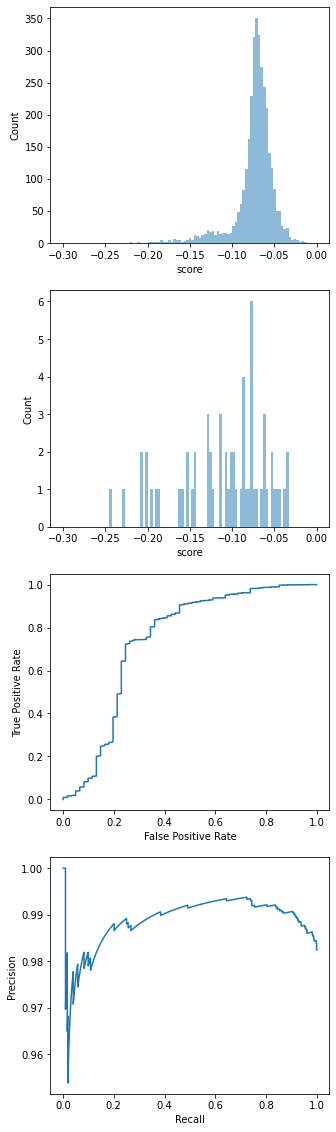

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, roc_curve
from math import sqrt
from matplotlib import pyplot
import numpy as np

model_name = "oc-carb-fine-tuning-10k"

result = pd.read_csv(f"{drive_root}ErukaTraining/models/{model_name}_results.csv")

print(f"All results: {len(result)}")

correct = result[result['target'] == result['prediction']]
print(f"Correct results: {len(correct)}")

incorrect = result[result['target'] != result['prediction']]
print(f"Incorrect results: {len(incorrect)}")
# print(incorrect.to_string())

result = result.astype({'target':'int', 'prediction':'int'})
filtered = result[result['prediction'] < 99999]

rmse = sqrt(mean_squared_error(filtered['target'], filtered['prediction'])) 
print(f"RMSE: {rmse}")

mae = mean_absolute_error(filtered['target'], filtered['prediction'])
print(f"MAE: {mae}")

bins = np.linspace(-0.3, 0, 100)

prefix = "tensor("
suffix = ", device='cuda:0')"
correct_scores = [float(s[s.startswith(prefix) and len(prefix):s.endswith(suffix) and len(s)-len(suffix)]) for s in correct['score'].values]
incorrect_scores = [float(s[s.startswith(prefix) and len(prefix):s.endswith(suffix) and len(s)-len(suffix)]) for s in incorrect['score'].values]
# correct_scores = [s.cpu() for s in correct['score'].values]
# incorrect_scores = [s.cpu() for s in incorrect['score'].values]

correct_scores_df = pd.DataFrame(correct_scores)
print("Correct score stats:", correct_scores_df.describe())

incorrect_scores_df = pd.DataFrame(incorrect_scores)
print("Incorrect score stats:", incorrect_scores_df.describe())

result_y = result.copy()
result_y['y'] = np.where(result_y['target'] == result_y['prediction'], True, False)
y_score = [float(s[s.startswith(prefix) and len(prefix):s.endswith(suffix) and len(s)-len(suffix)]) for s in result['score'].values]
# y_score = [s.cpu() for s in result['score'].values]
y = result_y['y']

fpr, tpr, thresholds = roc_curve(y, y_score)

results_sorted_df = result.sort_values(by='score', ascending=True)

num_correct = 0
total = 0
recall = []
precision = []
threshold = ""
best_precision = 0

for index, row in results_sorted_df.iterrows():
    total += 1
    if row["target"] == row["prediction"]:
        num_correct += 1
        row_recall = num_correct / len(correct)
        row_precision = num_correct / total
        recall.append(row_recall)
        precision.append(row_precision)

        if row_recall > 0.5 and row_precision > best_precision:
            best_precision = row_precision
            threshold = row["score"]

print(f"Threshold: {threshold}")

thresholded = filtered[filtered['score'] < threshold]

print(f"All thresholded: {len(thresholded)}")

correct = thresholded[thresholded['target'] == thresholded['prediction']]
print(f"Correct thresholded: {len(correct)}")

incorrect = thresholded[thresholded['target'] != thresholded['prediction']]
print(f"Incorrect thresholded: {len(incorrect)}")
print(f"Incorrect ent")

rmse = sqrt(mean_squared_error(thresholded['target'], thresholded['prediction'])) 
print(f"Thresholded RMSE: {rmse}")

mae = mean_absolute_error(thresholded['target'], thresholded['prediction'])
print(f"Thresholded MAE: {mae}")

fig, axs = pyplot.subplots(4, figsize=(5, 20))
axs[0].hist(correct_scores, bins, alpha=0.5, label='correct')
axs[0].set(xlabel='score', ylabel='Count')
axs[1].hist(incorrect_scores, bins, alpha=0.5, label='incorrect')
axs[1].set(xlabel='score', ylabel='Count')
axs[2].plot(fpr,tpr)
axs[2].set(xlabel='False Positive Rate', ylabel='True Positive Rate')
axs[3].plot(recall,precision)
axs[3].set(xlabel='Recall', ylabel='Precision')
pyplot.show()



# Appendix - Split test and train sets

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

all_labels_df = pd.read_csv(f"{drive_root}ErukaTraining/OC/labels_raw.csv")
inf_count = np.isfinite(all_labels_df['building_value']).values.sum()
all_labels_df = all_labels_df.dropna()
print("Raw labels: ", len(all_labels_df))
all_labels_df['building_value'] = all_labels_df['building_value'].astype(int)
print(all_labels_df.head())

image_files = fnmatch.filter(os.listdir(f"{drive_root}ErukaTraining/OC/images/"), "*.jpg")
print("Input images: ", len(image_files))
images_df = pd.DataFrame([image[:-4] for image in image_files], columns=["files"])
print(images_df.head())

valid_labels = pd.merge(images_df, all_labels_df, how="inner", left_on="files", right_on="parcelid")
valid_labels = valid_labels.drop("files", axis=1)
print("Raw labels: ", len(valid_labels))
print(valid_labels.head())

train, test = train_test_split(valid_labels, train_size=7200, random_state=42, shuffle=True)
train.to_csv(f"{drive_root}ErukaTraining/OC/labels.csv", index=False)
test.to_csv(f"{drive_root}ErukaTraining/OC/labels_test.csv", index=False)

Raw labels:  12270
12269
Raw labels:  12269
        parcelid  building_value
0  0590006004100            3140
1  1190001019100            4270
2  1790077012500            3250
3  2430003008600            2720
4  0380006005600            4910


<ipython-input-18-173d98c54863>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_labels_df['building_value'] = all_labels_df['building_value'].astype(int)


Input images:  11534
           files
0  1730001021000
1  5820006011100
2  0960002011500
3  2080056016700
4  2100073007700
Raw labels:  10561
        parcelid  building_value
0  5820006011100            2270
1  0960002011500            1530
2  2080056016700            4170
3  2100073007700            7230
4  2180057001700            4460


# Inference using trained model

In [ ]:
class OCInferenceDataset(torch.utils.data.Dataset):

    def __init__(self, processor, dir, max_target_length=16) -> None:
        image_files = fnmatch.filter(os.listdir(dir), "*.jpg")

        self.X = []

        for image_file in image_files:
            # Extract pixel values
            file_path = f"{dir}{image_file}"
            parcel = image_file[:-4]
            # pixel_values.to(device)
            
            # Resolve parcel values
            parcel_tokens = processor.tokenizer(parcel, 
                padding="max_length", 
                max_length=max_target_length).input_ids
            parcel_tokens = torch.tensor(parcel_tokens)

            self.X.append({"file_path": file_path, "parcel_tokens": parcel_tokens})

    def __len__(self):
        return len(self.X)

    def __getitem__(self, ind):
        x = self.X[ind]
        image = Image.open(x["file_path"]).convert("RGB")
        pixel_values = processor(image, return_tensors="pt").pixel_values.squeeze(0)

        return {"pixel_values": pixel_values, "parcel_tokens": x["parcel_tokens"]}

oc_inference_dataset = OCInferenceDataset(processor, f"{drive_root}ErukaTraining/OC/images/")

In [ ]:
generate_args = {"max_length": 16, "num_beams": 4, "return_dict_in_generate": True, "output_scores": True}
result_df = pd.DataFrame(columns=["parcelid", "prediction", "score"])
test_loader = DataLoader(oc_inference_dataset, batch_size=8, shuffle=False, collate_fn=default_data_collator)

for batch in test_loader:
    pixel_values = batch["pixel_values"].to("cuda")
    outputs = model.generate(pixel_values, **generate_args)
    generated_ids = outputs.sequences
    scores = outputs.sequences_scores
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)
    # generated_text = generated_text.translate({ord(c): None for c in ' ,.'})

    parcelids = processor.batch_decode(batch["parcel_tokens"], skip_special_tokens=True)

    result_df = result_df.append(pd.DataFrame(list(zip(parcelids, generated_text, scores.to("cpu").tolist())), columns=["parcelid", "prediction", "score"]))
    break

print(result_df.to_string())

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "output_scores": true,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}



KeyboardInterrupt: ignored